In [1]:
import torch
torch.set_default_device('cpu')
torch.set_default_dtype(torch.float64)
import sys
sys.path.append("../")
from simulations.simulator import wiener
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import pickle
import pandas as pd
import arviz

In [2]:
path = "../../results_for_paper/WinerHammersteinReal/wiener_hamemrstein"
path = "../../results_for_paper/CED/CED1"
#path = "../../results_for_paper/electricity_victoria/ele"
path = "../../results_for_paper/ETTh1/ETTh1"
path = "../results/ETTh/ETTh1"
with open(path+"data", 'rb') as f:
    data = pickle.load(f)
dNN = pd.read_csv(path+"dyno.csv",header=None)
with open(path+"gp_means", 'rb') as f:
    predictive_means = pickle.load(f)
with open(path+"gp_vars", 'rb') as f:
    predictive_variances = pickle.load(f)
    
dNN.shape
t_tr= data[0][...,0].numpy()
u_tr= data[0][...,1:].numpy()
t_te= data[2][...,0].numpy()
u_te= data[2][...,1:].numpy()
y_tr= data[1].numpy()
y_te= data[3].numpy()

test_y_hat_NN = dNN.values


In [3]:
predictive_variances.shape

(1, 200, 17420)

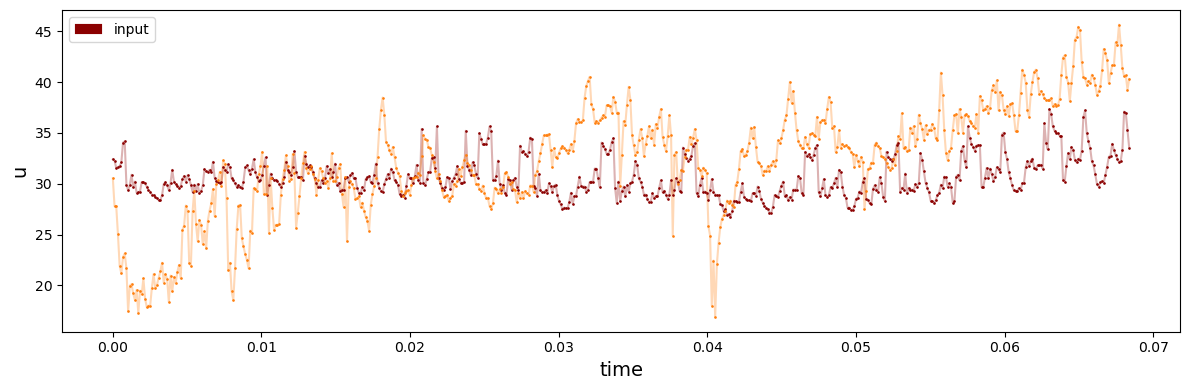

In [84]:
fig,ax=plt.subplots(figsize=(12,4))
uall=u_te[...,0:600,4]*2#np.stack([u_tr.flatten(),u_te.flatten()])
tall=t_te[...,0:600] #np.stack([t_tr.flatten(),t_te.flatten()])
ax.scatter(tall.flatten(),uall.flatten()+24,color='darkred',s=0.8,zorder=1e6,label="data")
plt.plot(tall.flatten(),uall.flatten()+24,color='darkred',alpha=0.3)
ax.scatter(tall.flatten(),y_te.flatten()[0:600],color='C1',s=0.8,zorder=1e6,label="data")
plt.plot(tall.flatten(),y_te.flatten()[0:600],color='C1',alpha=0.3)

plt.legend()
plt.ylabel("u",fontsize=14)
plt.xlabel("time",fontsize=14)
#ax.axvline(t_tr[0,-1],color='black')
r_patch = mpatches.Patch(color='darkred', label='input',linewidth=0.1)
plt.legend(handles=[r_patch])
plt.tight_layout()
plt.savefig("CED1_input.pdf")

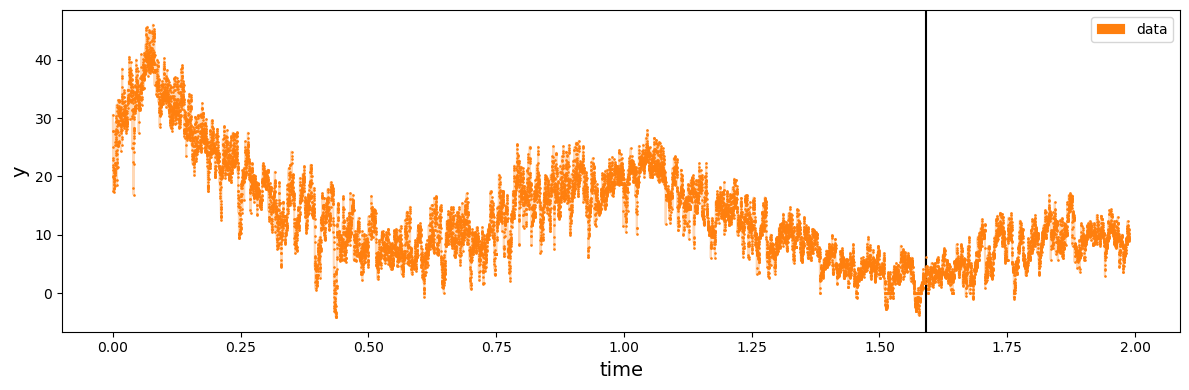

In [72]:


fig,ax=plt.subplots(figsize=(12,4))
ax.scatter(t_te.flatten(),y_te.flatten(),color='C1',s=0.8,zorder=1e6,label="data")
plt.plot(t_te.flatten(),y_te.flatten(),color='C1',alpha=0.3)
plt.legend()
plt.ylabel("y",fontsize=14)
plt.xlabel("time",fontsize=14)
ax.axvline(t_tr[0,-1],color='black')
r_patch = mpatches.Patch(color='C1', label='data',linewidth=0.1)
plt.legend(handles=[r_patch])
plt.tight_layout()
#plt.savefig("ele_victoria_output.pdf")

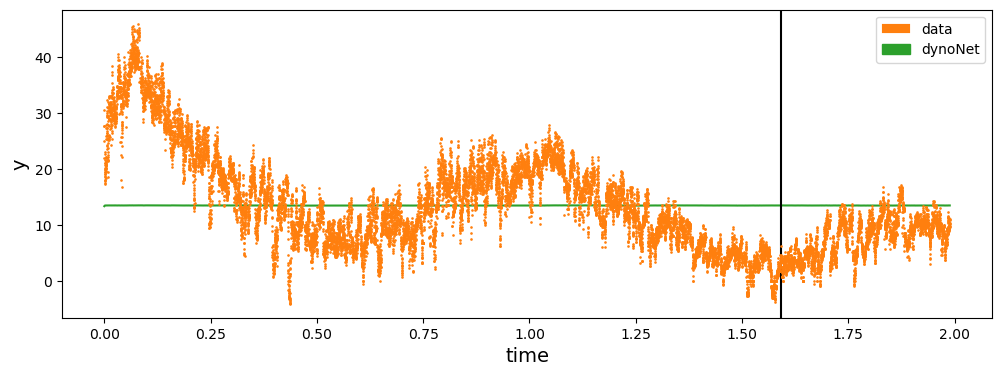

In [73]:

time_tep = t_te

for i in range(t_te.shape[0]):
    fig,ax=plt.subplots(figsize=(12,4))
    ax.scatter(time_tep[i].flatten(),y_te[i].flatten(),color='C1',s=0.8,zorder=1e6,label="data")
    ax.plot(time_tep[i].flatten(),test_y_hat_NN[i],label="dynoNet",color='C2')
    ax.axvline(t_tr[:,-1],color='black')
    plt.ylabel("y",fontsize=14)
    plt.xlabel("time",fontsize=14)
    r_patch = mpatches.Patch(color='C1', label='data',linewidth=0.1)
    b_patch = mpatches.Patch(color='C2', label='dynoNet')
    plt.legend(handles=[r_patch,b_patch])
#ax.plot(time_tep.flatten(),np.mean(samples,axis=0).flatten(),'darkblue')
#ax.set_xlim([10.1,22.5])
#ax.set_ylim([-1.5,6.0])
#plt.savefig("ele_dynonet.pdf")

In [74]:
np.sqrt(np.mean(abs(test_y_hat_NN.flatten()-y_te.flatten())**2))

8.564004792322903

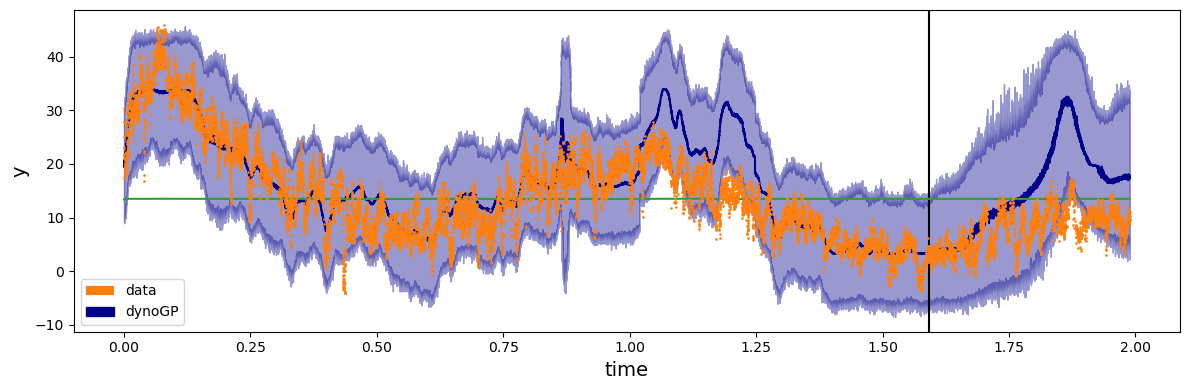

In [75]:
from functions.plotting import plot_gp_dist
for ui in range(t_te.shape[0]):
    fig,ax=plt.subplots(figsize=(12,4))
    ax.scatter(time_tep[ui].flatten(),y_te[ui].flatten(),color='C1',s=0.8,zorder=1e6,label="data")
    #meanp = predictive_means.mean(axis=0).flatten()
    samples=[]
    nsamples=3000
    for i in range(nsamples):
        j = np.random.randint(predictive_means[ui].shape[0])
        s = predictive_means[ui][j,:]+np.sqrt(predictive_variances[ui][j,:])*np.random.randn(predictive_variances.shape[2])
        samples.append(s)
    samples = np.vstack(samples)
    ci = arviz.hdi(samples[None,:],hdi_prob=0.997)
    #plot_gp_dist(ax,samples,time_tep.flatten(),samples_alpha=0.3,palette='Blues',label=None)
    ax.plot(time_tep[ui].flatten(),np.median(predictive_means,axis=1).flatten(),'darkblue')
    #'ax.plot(time_tep[ui].flatten(),predictive_means[0,190,:].flatten(),'darkblue')
    ax.fill_between(time_tep[ui].flatten(),ci[:,0],ci[:,1], alpha=0.4,color='darkblue')
    ax.axvline(t_tr[0,-1],color='black')
    ax.set_ylabel("y",fontsize=14)
    ax.set_xlabel("time",fontsize=14)
    #ax.set_ylim([-5,20])
    r_patch = mpatches.Patch(color='C1', label='data',linewidth=0.1)
    b_patch = mpatches.Patch(color='darkblue', label='dynoGP')
    plt.legend(handles=[r_patch,b_patch])
    plt.tight_layout()
    ax.plot(time_tep[0].flatten(),test_y_hat_NN[0],label="dynoNet",color='C2')
    #plt.savefig("ele_victoria_dynogp.pdf")


In [36]:
test_y_hat_GP = np.median(samples,axis=0)
import properscoring as ps
shift=400
shiftdown=None
print("RMSE:", np.sqrt(np.mean(abs(test_y_hat_GP.flatten()[shift:shiftdown]-y_te.flatten()[shift:shiftdown])**2)),
      "MAE:", (np.mean(abs(test_y_hat_GP.flatten()[shift:shiftdown]-y_te.flatten()[shift:shiftdown]))),
      "CRPS", np.mean(ps.crps_ensemble(y_te.flatten()[shift:shiftdown],samples[:,shift:shiftdown].T)))
print("RMSE:", np.sqrt(np.mean(abs(test_y_hat_NN.flatten()[shift:shiftdown]-y_te.flatten()[shift:shiftdown])**2)),
      "MAE:", (np.mean(abs(test_y_hat_NN.flatten()[shift:shiftdown]-y_te.flatten()[shift:shiftdown]))),
      "CRPS",None)

RMSE: 2.872804982010772 MAE: 2.2060814134310296 CRPS 1.6217770887474603
RMSE: 8.24234771693729 MAE: 6.533404898340653 CRPS None


In [69]:
samples.shape

(2000, 10736)

5.788061893585876 3.4445275548628693


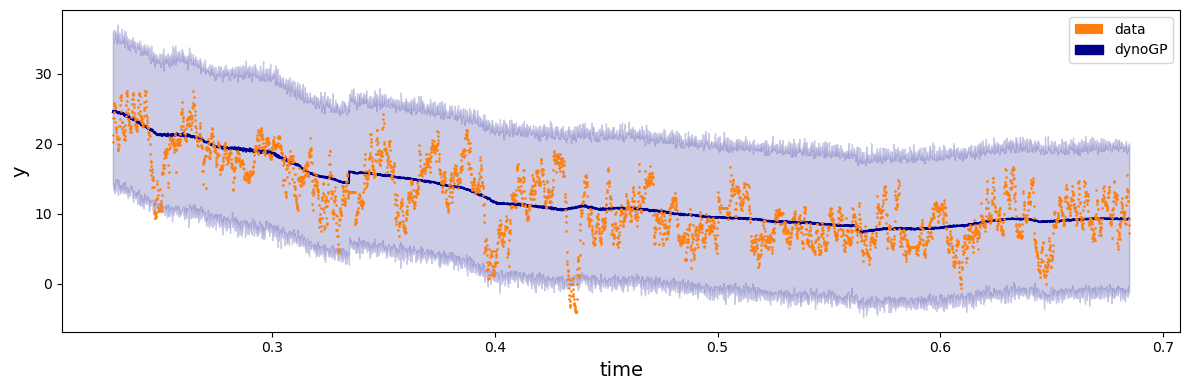

In [49]:
fig,ax=plt.subplots(figsize=(12,4))
le=2000#3416#4416
re=le+4000
ax.scatter(time_tep.flatten()[le:re],y_te.flatten()[le:re],color='C1',s=0.8,zorder=1e6,label="data")
#meanp = predictive_means.mean(axis=0).flatten()

#plot_gp_dist(ax,samples,time_tep.flatten(),samples_alpha=0.1,palette='Blues',label=None)
#ax.plot(time_tep.flatten()[le:re],np.mean(samples,axis=0).flatten()[le:re],'darkblue')
ax.plot(time_tep[ui].flatten()[le:re],np.median(predictive_means,axis=1).flatten()[le:re],'darkblue')
#ax.plot(time_tep.flatten()[le:re],test_y_hat_NN.flatten()[le:re],'green')
#plot_gp_dist(ax,samples[:,le:re],time_tep.flatten()[le:re],samples_alpha=0.1,palette='Blues',label=None)
#ax.plot(time_tep.flatten()[le:re],test_y_hat_NN.flatten()[le:re],label="dynoNet",color='C2')
ax.fill_between(time_tep.flatten()[le:re],ci[:,0][le:re],ci[:,1][le:re], alpha=0.2,color='darkblue')
print(np.sqrt(np.mean(abs(test_y_hat_NN.flatten()[le:re]-y_te.flatten()[le:re])**2)),
      np.sqrt(np.mean(abs(test_y_hat_GP.flatten()[le:re]-y_te.flatten()[le:re])**2)))
ax.set_ylabel("y",fontsize=14)
ax.set_xlabel("time",fontsize=14)

r_patch = mpatches.Patch(color='C1', label='data',linewidth=0.1)
b_patch = mpatches.Patch(color='darkblue', label='dynoGP')
plt.legend(handles=[r_patch,b_patch])
plt.tight_layout()
plt.savefig("ele_zoom.pdf")

In [87]:
import properscoring as ps
np.mean(ps.crps_ensemble(y_te.flatten(),samples.T))

0.03085687980127043

In [66]:
np.mean(ps.crps_ensemble(y_te.flatten(),test_y_hat_GP.T))

0.04175232904392774

In [21]:
test_y_hat_GP.shape

(1, 16384)

In [131]:
np.random.seed(1)
ps.crps_ensemble(0,np.random.randn(1000)*0.55+0.1)

0.13489796446597183

In [88]:
time= torch.tensor(np.sort(3*np.random.rand(10)))
time

tensor([0.1051, 0.7141, 0.8680, 1.4173, 1.4626, 1.6326, 2.0477, 2.0967, 2.6857,
        2.7593])

In [90]:
lent=torch.max(time)
num_inducing=10
torch.multinomial(torch.log1p(time.flatten()/lent)/torch.log1p(torch.tensor(1)),num_inducing-1)

tensor([3, 5, 2, 8, 1, 7, 6, 9, 4])

In [92]:
torch.sum(torch.log1p(time.flatten()/lent)/torch.log1p(torch.tensor(1)))

tensor(6.2597)

In [93]:
? torch.multinomial

Docstring:
multinomial(input, num_samples, replacement=False, *, generator=None, out=None) -> LongTensor

Returns a tensor where each row contains :attr:`num_samples` indices sampled
from the multinomial (a stricter definition would be multivariate,
refer to :class:`torch.distributions.multinomial.Multinomial` for more details)
probability distribution located in the corresponding row
of tensor :attr:`input`.

.. note::
    The rows of :attr:`input` do not need to sum to one (in which case we use
    the values as weights), but must be non-negative, finite and have
    a non-zero sum.

Indices are ordered from left to right according to when each was sampled
(first samples are placed in first column).

If :attr:`input` is a vector, :attr:`out` is a vector of size :attr:`num_samples`.

If :attr:`input` is a matrix with `m` rows, :attr:`out` is an matrix of shape
:math:`(m \times \text{num\_samples})`.

If replacement is ``True``, samples are drawn with replacement.

If not, they are dra